In [1]:
using Turing
using DataFrames
using CSV
using Plots
using Distributions

In [2]:
df = CSV.read("GRB_data.txt",  DataFrame, header=[:logt90, :dlogt90, :logHR])

Row,logt90,dlogt90,logHR
,Float64,Float64,Float64
1,1.64558,0.0349151,0.419301
2,5.3403,0.00536016,0.0336968
3,1.14295,0.188138,0.589931
4,4.50176,0.00317158,0.501586
5,6.06382,0.00254409,0.036883
6,4.58676,0.0230403,0.52872
7,5.94345,0.0267333,0.0625971
8,4.31759,0.0170648,0.0542884
9,4.12636,0.00807076,0.427434


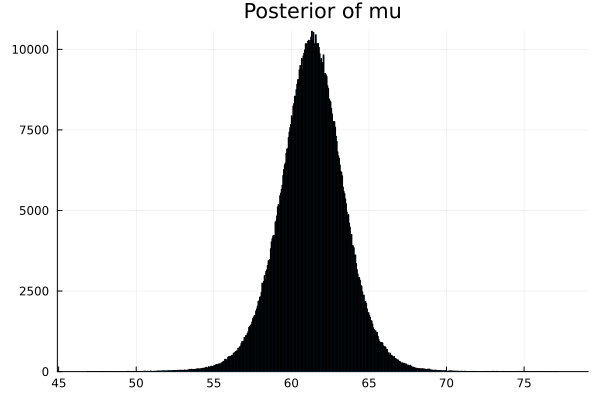

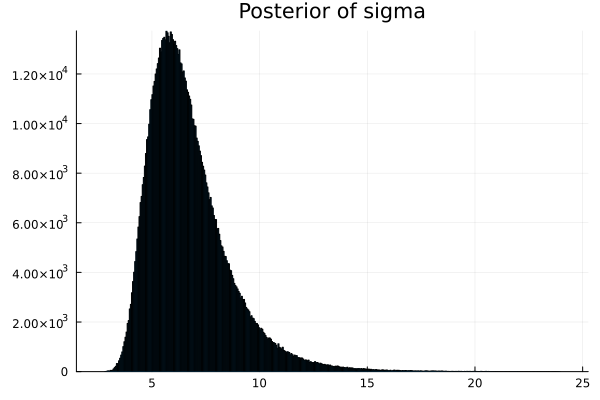

In [22]:
# Here are the weights of the students (in kilograms) in a classrom
# Assuming the weight of the students are generated by a biological
# process with a normal distribution with mean μ and standard dev σ
# find the posterior distribution of those two parameters
data = [ 55.8, 64.1, 61.2, 55.2, 58.0, 69.8, 53.2, 70.0, 63.3, 63.5 ]

# define our prior for μ as a normal centered on 60 ( required for MCMC )
prior_μ_distr = Distributions.Normal(60, 10)
prior_μ(p) = Distributions.pdf(prior_μ_distr,p)
μ_lb = 30       # Lower bound
μ_ub = 90       # Upper bound

# define our prior for σ as a exponential with mean of 20 ( required for MCMC )
prior_σ_distr = Distributions.Exponential(20)
prior_σ(p) = Distributions.pdf(prior_σ_distr,p)
σ_lb = 0        # Lower bound
σ_ub = 50       # Upper bound

# define the number of samples used in MCMC
# And create array parameter with that many elements (filled with 0.0)
burnedinsamples = 1000
n_samples = 1_000_000 + burnedinsamples
p_μ = zeros(n_samples)
p_σ = zeros(n_samples)

# Set the starting value to a random number between lb and ub
p_μ[1] = rand(prior_μ_distr)
while p_μ[1] < μ_lb || p_μ[1] > μ_ub
    p_μ[1] = rand(prior_μ_distr)
end

p_σ[1] = rand(prior_σ_distr)
while p_σ[1] < σ_lb || p_σ[1] > σ_ub
    p_σ[1] = rand(prior_σ_distr)
end


# The likelihood function which returns the probability,
# given a fixed mu and a fixed sigma, of the sequence of datapoints
function loglikelihood(data::Vector,mu::Real,sigma::Real)
    numofdatapoints = length(data)
    result=0.0
    for k = 1:numofdatapoints
        result += log(  pdf(Normal(mu, sigma),data[k])  )
    end
    return result
end

JumpingWidth = 0.01
for i in 2:n_samples
    # p_new has a value around the vicinity of p[i-1]
    p_μ_new = rand(  Normal( p_μ[i-1] , JumpingWidth*(μ_ub-μ_lb) )  )
    # make sure p_μ_new is between μ_lb and μ_ub
    if p_μ_new < μ_lb
        p_μ_new = μ_lb + abs( p_μ_new - μ_lb )
    elseif p_μ_new > μ_ub
        p_μ_new = μ_ub - abs( p_μ_new - μ_ub )
    end

    p_σ_new = rand(  Normal( p_σ[i-1] , JumpingWidth*(σ_ub-σ_lb) )  )
    # make sure p_σ_new is between σ_lb  and σ_ub
    if p_σ_new < σ_lb
        p_σ_new = σ_lb + abs( p_σ_new - σ_lb )
    elseif p_σ_new > σ_ub
        p_σ_new = σ_ub - abs( p_σ_new - σ_ub )
    end
    " q0 is posterior0 = likelihood0 * prior0        "
    " q1 is posterior1 = likelihood1 * prior1        "
#=
q0  is the probability for the CURRENT POSITION
q1  is the probability for the CANDIDATE for the NEW POSITION
=#
    logpriorμ0 = log(  prior_μ(p_μ[i-1])  )
    logpriorσ0 = log(  prior_σ(p_σ[i-1])  )
    logpriorμ1 = log(  prior_μ(p_μ_new)   )
    logpriorσ1 = log(  prior_σ(p_σ_new)   )

    logq0 = loglikelihood(data, p_μ[i-1], p_σ[i-1]) + logpriorμ0 + logpriorσ0
    logq1 = loglikelihood(data, p_μ_new, p_σ_new) + logpriorμ1 + logpriorσ1
    # The value of parameter[i] depends on whether the
    # log(random number) is less than logq1 - logq0
#=
If  the probability for the CANDIDATE for the NEW POSITION (q1)
    is GREATER than
the probability for the CURRENT POSITION (q0)
then jump to the NEW POSITION

Otherwise

Only jump to the CANDIDATE for the NEW POSITION if
a random number (between 0.0 and 1.0) is less than   q1/q0
=#
    if log(rand()) < logq1 - logq0    # Then jump to the NEW POSITION
        p_μ[i] = p_μ_new
        p_σ[i] = p_σ_new
    else        # Stick with the CURRENT POSITION
        p_μ[i] = p_μ[i-1]
        p_σ[i] = p_σ[i-1]
    end


end

# Finally we must not forget to remove the burned in samples
deleteat!(p_μ,1:burnedinsamples)
deleteat!(p_σ,1:burnedinsamples)

# Next we need to display the histogram of the array p
# this is the shape of the posterior produced by MCMC
histogram(p_μ,legend=false,title="Posterior of mu") |> display
histogram(p_σ,legend=false,title="Posterior of sigma") |> display

# Gaussian Mixture Models

In [8]:
using Distributions
using FillArrays
using StatsPlots

using LinearAlgebra
using Random

# Set a random seed.
Random.seed!(3)

# Define Gaussian mixture model.
w = [0.5, 0.5]
μ = [-3.5, 0.5]
mixturemodel = MixtureModel([MvNormal(Fill(μₖ, 2), I) for μₖ in μ], w)

# We draw the data points.
N = 60
x = rand(mixturemodel, N);

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]

[27366] signal (2): Interrupt: 2
in expression starting at /Users/zenith378/.julia/packages/Clustering/tyftt/src/Clustering.jl:3

[27364] signal (2): Interrupt: 2
in expression starting at /Users/zenith378/.julia/packages/StatsPlots/appIH/src/StatsPlots.jl:18
kevent at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
Allocations: 1207680 (Pool: 1206429; Big: 1251); GC: 2
error in running finalizer: ErrorException("val already in a list")
kevent at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
Allocations: 2906 (Pool: 2897; Big: 9); GC: 0
error in running finalizer: ErrorException("val already in a list")
error at ./error.jl:35
push! at ./linked_list.jl:53 [inlined]
_wait2 at ./condition.jl:87
#wait#645 at ./condition.jl:127
wait at ./condition.jl:125 [inlined]
close at ./asyncevent.jl:180
close at /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4

LoadError: Failed to precompile StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd] to "/Users/zenith378/.julia/compiled/v1.10/StatsPlots/jl_5LMOWm".

fatal: error thrown and no exception handler available.
InterruptException()
ijl_restore_system_image_data at /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-grannysmith-C07ZQ07RJYVY.0/build/default-grannysmith-C07ZQ07RJYVY-0/julialang/julia-release-1-dot-10/src/staticdata.c:3525
jl_load_sysimg_so at /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-grannysmith-C07ZQ07RJYVY.0/build/default-grannysmith-C07ZQ07RJYVY-0/julialang/julia-release-1-dot-10/src/staticdata.c:586 [inlined]
ijl_restore_system_image at /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-grannysmith-C07ZQ07RJYVY.0/build/default-grannysmith-C07ZQ07RJYVY-0/julialang/julia-release-1-dot-10/src/staticdata.c:3494
_finish_julia_init at /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-grannysmith-C07ZQ07RJYVY.0/build/default-grannysmith-C07ZQ07RJYVY-0/julialang

In [18]:
using Turing

@model function gaussian_mixture_model(x)
    # Draw the parameters for each of the K=2 clusters from a standard normal distribution.
    K = 2
    μ ~ MvNormal(Zeros(K), 1)

    # Draw the weights for the K clusters from a Dirichlet distribution with parameters αₖ = 1.
    w ~ Dirichlet(K, 1.0)
    # Alternatively, one could use a fixed set of weights.
    # w = fill(1/K, K)

    # Construct categorical distribution of assignments.
    distribution_assignments = Categorical(w)

    # Construct multivariate normal distributions of each cluster.
    D, N = size(df.logt90)
    distribution_clusters = MvNormal(Fill(μₖ, D), 1) for μₖ in μ]

    # Draw assignments for each datum and generate it from the multivariate normal distribution.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ distribution_assignments
        x[i] ~ distribution_clusters[k[i]]
    end

    return k
end

model = gaussian_mixture_model(df.logt90);

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/zenith378/Documents/Uni/GRBurst_Bayesian_Probability/In[18]#18:54\[90mIn[18]:18:54[0;0m]8;;\
    D, N = size(df.logt90)
    distribution_clusters = MvNormal(Fill(μₖ, D), 1) [48;2;120;70;70mfor μₖ in μ[0;0m]
[90m#                                                    └─────────┘ ── [0;0m[91mExpected `end`[0;0m

In [16]:
model

DynamicPPL.Model{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(gaussian_mixture_model, (x = [1.6455769590499738, 5.340303483215096, 1.1429481024881614, 4.501763316276215, 6.0638224172976845, 4.586761786304737, 5.943450082006223, 4.317594774514492, 4.126359891654112, 5.204094595300666  …  4.107589788972121, 3.852357923106411, -0.6694306539426292, 3.188664009459961, 2.7191879455126657, 0.6184236343640089, 4.186498250392645, -0.8627499649461253, 2.830857630363757, 4.169823023398005],), NamedTuple(), DynamicPPL.DefaultContext())

In [17]:
sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ, :w))
nsamples = 100
nchains = 3
chains = sample(model, sampler, MCMCThreads(), nsamples, nchains);


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296


LoadError: TaskFailedException

[91m    nested task error: [39mTaskFailedException
    
    [91m    nested task error: [39mBoundsError: attempt to access Tuple{Int64} at index [2]
        Stacktrace:
          [1] [0m[1mindexed_iterate[22m[0m[1m([22m[90mt[39m::[0mTuple[90m{Int64}[39m, [90mi[39m::[0mInt64, [90mstate[39m::[0mInt64[0m[1m)[22m
        [90m    @[39m [90mBase[39m [90m./[39m[90m[4mtuple.jl:92[24m[39m
          [2] [0m[1mgaussian_mixture_model[22m[0m[1m([22m[90m__model__[39m::[0mDynamicPPL.Model[90m{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90m__varinfo__[39m::[0mDynamicPPL.UntypedVarInfo[90m{DynamicPPL.Metadata{Dict{AbstractPPL.VarName, Int64}, Vector{Distribution}, Vector{AbstractPPL.VarName}, Vector{Real}, Vector{Set{DynamicPPL.Selector}}}, Float64}[39m, [90m__context__[39m::[0mDynamicPPL.SamplingContext[90m{DynamicPPL.SampleFromPrior, DynamicPPL.DefaultContext, Random.TaskLocalRNG}[39m, [90mx[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
        [90m    @[39m [33mMain[39m [90m./[39m[90m[4mIn[15]:17[24m[39m
          [3] [0m[1m_evaluate!![22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4mmodel.jl:963[24m[39m[90m [inlined][39m
          [4] [0m[1mevaluate_threadunsafe!![22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4mmodel.jl:936[24m[39m[90m [inlined][39m
          [5] [0m[1mevaluate!![22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4mmodel.jl:889[24m[39m[90m [inlined][39m
          [6] [0m[1mevaluate!![22m[0m[1m([22m[90mmodel[39m::[0mDynamicPPL.Model[90m{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90mrng[39m::[0mRandom.TaskLocalRNG, [90mvarinfo[39m::[0mDynamicPPL.UntypedVarInfo[90m{DynamicPPL.Metadata{Dict{AbstractPPL.VarName, Int64}, Vector{Distribution}, Vector{AbstractPPL.VarName}, Vector{Real}, Vector{Set{DynamicPPL.Selector}}}, Float64}[39m, [90msampler[39m::[0mDynamicPPL.SampleFromPrior, [90mcontext[39m::[0mDynamicPPL.DefaultContext[0m[1m)[22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4mmodel.jl:900[24m[39m
          [7] [0m[1m(::DynamicPPL.Model{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext})[22m[0m[1m([22m::[0mRandom.TaskLocalRNG, ::[0mVararg[90m{Any}[39m[0m[1m)[22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4mmodel.jl:860[24m[39m
          [8] ([0m[1mDynamicPPL.TypedVarInfo[22m)[0m[1m([22m[90mvi[39m::[0mDynamicPPL.UntypedVarInfo[90m{DynamicPPL.Metadata{Dict{AbstractPPL.VarName, Int64}, Vector{Distribution}, Vector{AbstractPPL.VarName}, Vector{Real}, Vector{Set{DynamicPPL.Selector}}}, Float64}[39m[0m[1m)[22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4mvarinfo.jl:135[24m[39m[90m [inlined][39m
          [9] [0m[1mdefault_varinfo[22m
        [90m    @[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4msampler.jl:80[24m[39m[90m [inlined][39m
         [10] [0m[1mdefault_varinfo[22m
        [90m    @[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4msampler.jl:71[24m[39m[90m [inlined][39m
         [11] [0m[1mstep[22m[0m[1m([22m[90mrng[39m::[0mRandom.TaskLocalRNG, [90mmodel[39m::[0mDynamicPPL.Model[90m{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90mspl[39m::[0mDynamicPPL.Sampler[90m{Gibbs{(:k, :μ, :w), 2, Tuple{PG{(:k,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Essential.ForwardDiffAD{0}, (:μ, :w), AdvancedHMC.UnitEuclideanMetric}}, Tuple{Int64, Int64}}}[39m; [90mresume_from[39m::[0mNothing, [90minit_params[39m::[0mNothing, [90mkwargs[39m::[0m@Kwargs[90m{}[39m[0m[1m)[22m
        [90m    @[39m [35mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4msampler.jl:98[24m[39m
         [12] [0m[1mstep[22m
        [90m    @[39m [90m~/.julia/packages/DynamicPPL/oX6N7/src/[39m[90m[4msampler.jl:84[24m[39m[90m [inlined][39m
         [13] [0m[1mmacro expansion[22m
        [90m    @[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4msample.jl:125[24m[39m[90m [inlined][39m
         [14] [0m[1mmacro expansion[22m
        [90m    @[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4mlogging.jl:16[24m[39m[90m [inlined][39m
         [15] [0m[1mmcmcsample[22m[0m[1m([22m[90mrng[39m::[0mRandom.TaskLocalRNG, [90mmodel[39m::[0mDynamicPPL.Model[90m{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90msampler[39m::[0mDynamicPPL.Sampler[90m{Gibbs{(:k, :μ, :w), 2, Tuple{PG{(:k,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Essential.ForwardDiffAD{0}, (:μ, :w), AdvancedHMC.UnitEuclideanMetric}}, Tuple{Int64, Int64}}}[39m, [90mN[39m::[0mInt64; [90mprogress[39m::[0mBool, [90mprogressname[39m::[0mString, [90mcallback[39m::[0mNothing, [90mdiscard_initial[39m::[0mInt64, [90mthinning[39m::[0mInt64, [90mchain_type[39m::[0mType, [90mkwargs[39m::[0m@Kwargs[90m{init_params::Nothing}[39m[0m[1m)[22m
        [90m    @[39m [36mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4msample.jl:116[24m[39m
         [16] [0m[1mmcmcsample[22m
        [90m    @[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4msample.jl:95[24m[39m[90m [inlined][39m
         [17] [0m[1m#sample#3[22m
        [90m    @[39m [90m~/.julia/packages/Turing/UCuzt/src/mcmc/[39m[90m[4mInference.jl:204[24m[39m[90m [inlined][39m
         [18] [0m[1msample[22m
        [90m    @[39m [90m~/.julia/packages/Turing/UCuzt/src/mcmc/[39m[90m[4mInference.jl:193[24m[39m[90m [inlined][39m
         [19] [0m[1m(::AbstractMCMC.var"#36#49"{DynamicPPL.Sampler{Gibbs{(:k, :μ, :w), 2, Tuple{PG{(:k,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Essential.ForwardDiffAD{0}, (:μ, :w), AdvancedHMC.UnitEuclideanMetric}}, Tuple{Int64, Int64}}}, DynamicPPL.Model{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}, Random.TaskLocalRNG, UnitRange{Int64}, Bool, @Kwargs{chain_type::UnionAll}, Int64, Vector{Any}, Nothing, Vector{UInt64}})[22m[0m[1m([22m[0m[1m)[22m
        [90m    @[39m [36mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4msample.jl:370[24m[39m
    Stacktrace:
     [1] [0m[1msync_end[22m[0m[1m([22m[90mc[39m::[0mChannel[90m{Any}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mtask.jl:448[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mtask.jl:480[24m[39m[90m [inlined][39m
     [3] [0m[1m(::AbstractMCMC.var"#35#48"{Bool, @Kwargs{chain_type::UnionAll}, Int64, Int64, Vector{Any}, Nothing, Vector{UInt64}, Vector{DynamicPPL.Sampler{Gibbs{(:k, :μ, :w), 2, Tuple{PG{(:k,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Essential.ForwardDiffAD{0}, (:μ, :w), AdvancedHMC.UnitEuclideanMetric}}, Tuple{Int64, Int64}}}}, Vector{DynamicPPL.Model{typeof(gaussian_mixture_model), (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}}, Vector{Random.TaskLocalRNG}, Int64, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [36mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4msample.jl:349[24m[39m